In [1]:
# %load https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/pre.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 5 )
plt.rc('lines', linewidth = 5 )

plt.rc('lines', markersize = 5 )

plt.rc('figure', figsize=(8,4) )         # Image size


# What is Machine learning

There are different definitions for ML. This a diverse field and naturally, it is challenging to find a rigorous definition and problem statement that applies to all situations. However, a basic notion that is mostly accepted is that ML is the task of giving the machine the ability to learn without explicitly programming it. 

Now, we can ask, how it the learning defined?
There are a few elements that should be included:
- Experience that teaches the machine: This forms the training data
- Some metric of performance: This quantifies how well the machine has learned. 
- Target: This could be specifying a class or estimating a quantity or a combination of different things. 


For the most part of this course, our focus will the supervised learning, where the target values are known. For many physical applications, this is well-justified and the target values are determined either from experiment or computer simulations. 

We may get to reinforced learning towards the end as well. But supervised learning should be enough to cover most basic applications for your research. 

There are three main kind of problems:
- Regression: Estimation of a real-valued target 
- Logistic Regression: Estimation of a real-valued target between 0 and 1 which represents a probability
- Classification: Catergory-like target values

## Regression to Logistic Regression and Classification
One of the natural ways to extend the concepts we learned to Logistic regression and classification is to find a function that gives a boundary between the categories. This is often called "decision boundary". The logistic regression is connected to this function with a non-linear function, sometimes referred to as the activation function. For the classification it is usually easier and it is based on which side of the hyper-plane an instance falls. The distance from the decision boundary gives a notion of confidence in the classification. 

## Data
For this section, we use one of the datasets on Kaggle for particle identification. 
It is indicated on Kaggle that this is a 
"A somewhat simplified dataset of a GEANT based simulation of electron-proton inelastic scattering measured by a particle detector system."

See 
https://www.kaggle.com/naharrison/particle-identification-from-detector-responses/home

In [94]:
import io, requests, zipfile

In [96]:
url = 'https://doc-08-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l02fm8qlm2bd1i8l803p3r6ajic0bilm/1549951200000/12346087580104540467/*/1BgI0IhWMKBRI4j1-wyJlTysXdWOrK9Iz?e=download'
s=requests.get(url, stream=True).content
data=pd.read_csv(io.BytesIO(s) , compression='zip' )
 
'''
Alternatively, you can download the file into your computer and run the following code. 
You need to uncomment it first. 
'''    

# data = pd.read_csv('particle-identification-from-detector-responses.zip', compression='zip')
data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [100]:
'''
The 'id' indicates the particle type.
'''
from collections import Counter
targets = list(set(data['id']))
target_freq = [dict( Counter(data['id'])  )[ i] for i in targets]
features = list( data.columns[1:] )
print("There are {} types of particles in this set. \n Here are the target values and their frequencies: \n {}".format(4, dict( Counter(data['id'])  )  ))
# data['target'] = data['id'].apply(lambda x: np.argwhere( list(set(data['id'])) == x) )

'''
We can keep only a small portion of the data, 
this is to speed up the training in the class, 
otherwise, it is best to keep all of it.
'''
n_s = 10000
mini_data = data.sample(n_s, axis=0, random_state=0)
mini_data['target'] = mini_data['id'].apply(lambda x: targets.index(x)) 
mini_data.drop('id',axis=1, inplace=True)
mini_data.head()


There are 4 types of particles in this set. 
 Here are the target values and their frequencies: 
 {211: 2806833, 2212: 1945849, 321: 232471, -11: 14847}


,p,theta,beta,nphe,ein,eout,target
3748577,1.230330,0.415613,0.985857,0,0.182147,0.058503,1
4555504,0.870680,0.864884,0.989180,0,0.000000,0.000000,1
2388454,1.320670,0.481086,0.806984,0,0.151431,0.115267,2
3738046,0.657969,0.500238,0.982778,0,0.034974,0.055161,1
1572731,1.756310,0.340558,0.993275,0,0.030030,0.167452,1


/home/sraeisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


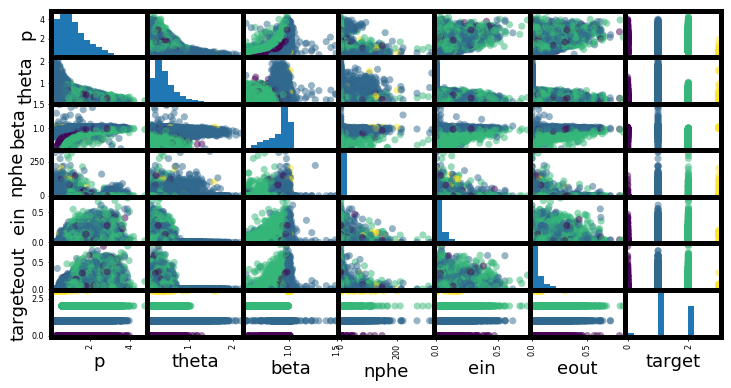

In [4]:
scatter = pd.scatter_matrix(mini_data, c=mini_data.target, 
                            figsize=(12,6), marker='o', s=50, 
                            hist_kwds={'bins':15})

## Binary Classificatoin 

There are four classes in our data, but for the first part, let's just keep two classes. 
There are two ways we can do this. We can either ignore the two less frequent classes (one_vs_one) 
or we can can keep one class and categorize the data to "is" and "is not" in that class (one_vs_rest).
I do the first one, you try the second one. Pick a class with reasonable bias. 

In [105]:
ind_1 = 1
ind_2 = 2
bmd = mini_data[ (mini_data['target']==ind_1) | (mini_data['target']==ind_2) ].copy()

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


In [107]:
Y = bmd['target']
X = bmd.drop('target',axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0)

### SGD

In [12]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train,Y_train)
print("The accurace of the SGD classifier is: {}".format( sgd_clf.score(X_test,Y_test) ) )
print("The coeeficients of the best fit are: {} and the intercept is:{} ".format( sgd_clf.coef_, sgd_clf.intercept_ ) )

The accurace of the SGD classifier is: 0.9554808903821923
The coeeficients of the best fit are: [[ 3.42975649 -1.15674736 -8.68414467 -1.84393539 -1.85942675  0.19844976]] and the intercept is:[-2.05783613] 


/home/sraeisi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### SVC

In [11]:
svc_clf = SVC()
svc_clf.fit(X_train,Y_train)
print("The accurace of the SVM classifier is: {}".format( svc_clf.score(X_test,Y_test) ) )
# print("The coeeficients of the best fit are: {} and the intercept is:{} ".format( svc_clf.coef_, svc_clf.intercept_ ) )

The accurace of the SVM classifier is: 0.9916001679966401


### Tree

In [17]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,Y_train)
print("The accuracy of the tree classifier is: {}".format( tree_clf.score(X_test,Y_test) ) )
print("The importance of features is: {}.".format( tree_clf.feature_importances_ ) )

The accurace of the tree classifier is: 0.9853002939941201
The importance of features is: [0.2918539  0.00387163 0.69513425 0.00211819 0.00365406 0.00336797].


### KNN

In [19]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,Y_train)
print("The accuracy of the knn classifier is: {}".format( knn_clf.score(X_test,Y_test) ) )

The accurace of the knn classifier is: 0.9798404031919362


### Bayes

In [47]:
nb_clf = GaussianNB()
nb_clf.fit(X_train,Y_train)
print("The accuracy of the knn classifier is: {}".format( nb_clf.score(X_test,Y_test) ) )

The accuracy of the knn classifier is: 0.9151616967660646


## Decision Boundary
### Comparison of the classifiers

In [97]:
'''
Some of the linear classifiers return a coef_ and intercept_ method 
which we can use to find the decidion boundary. 
Here we assume that there are only two features,
otherwise, it is not clear how to project the DB
into two D. 
The following function does just that.
'''
def dec_boundary(clf):
    w = clf.coef_ 
    b = clf.intercept_.reshape(  -1 ,1)
    '''
    It should return a function that takes in 
    X with a shape of (n_s, n_f)
    '''
    def func(x):
        return (np.dot(w , x.T ) + b).T
    
    return func
        

In [121]:
'''
Let's plot these classifiers and see how well the decision boundaries are.
The following function is borrowed from the sklean guides. 
'''
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z,  levels=[-.5, 0, .5], linestyles=['--', '-', '--'])
    out = ax.contourf(xx, yy, Z,   **params)
    return out

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional
    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max , h), np.arange(y_min, y_max , h) )
   
    return xx, yy

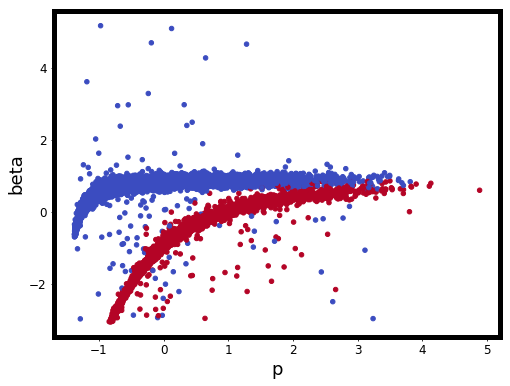

In [108]:
'''
Let's first see how the classes would look like.
'''
f_ind_1 = 0
f_ind_2 = 2
x_label = features[f_ind_1]
y_label = features[f_ind_2]
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, xlabel = x_label, ylabel=y_label)
ax.scatter(X[:,0],X[:,2], c= Y , cmap=plt.cm.coolwarm, s=20)
# ax.legend()
plt.show()

/home/sraeisi/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/sraeisi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


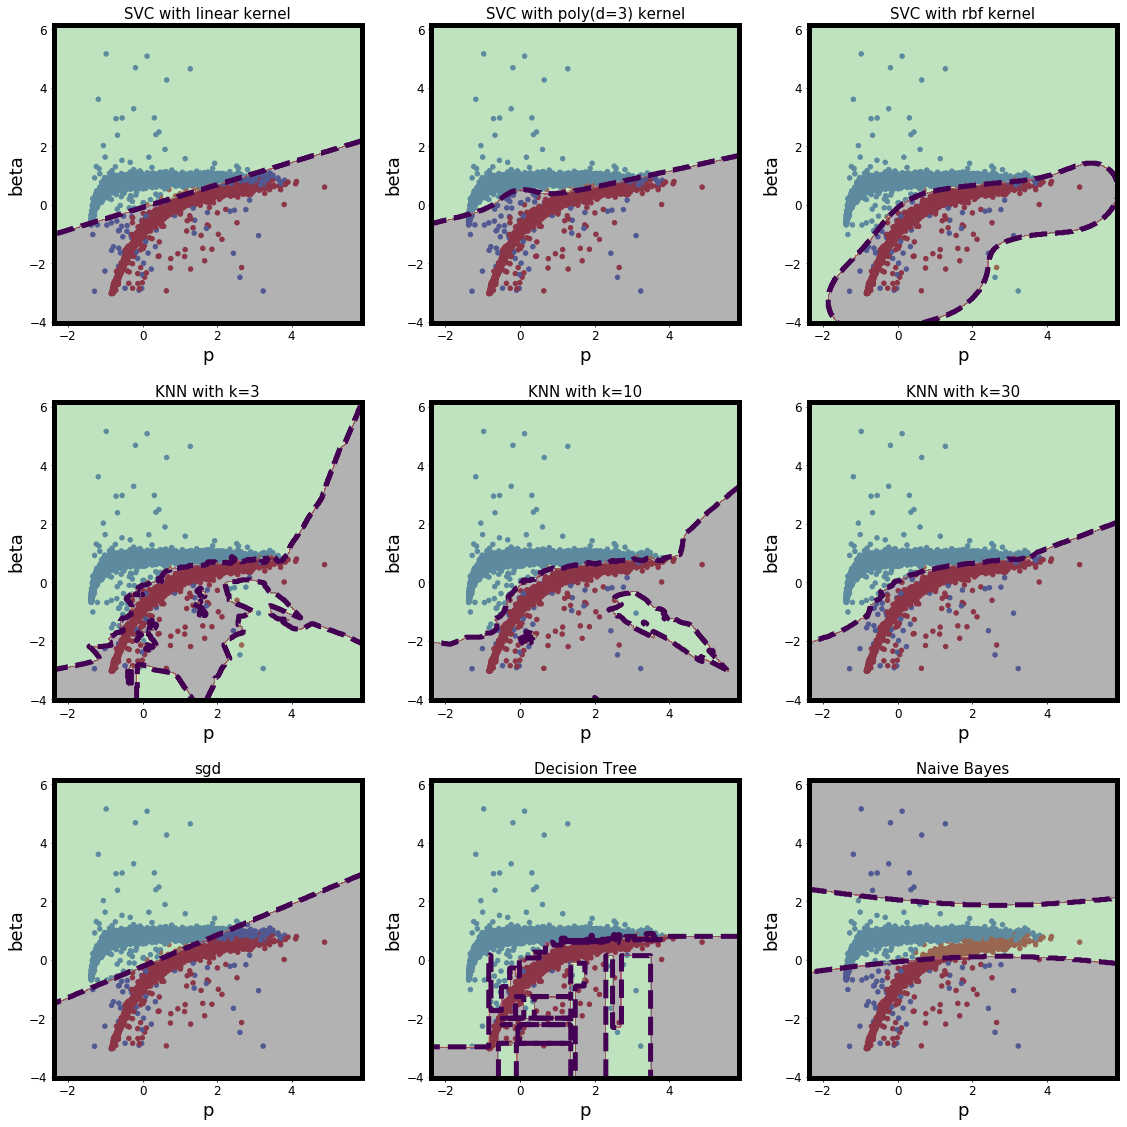

CPU times: user 48.8 s, sys: 312 ms, total: 49.2 s
Wall time: 48.2 s


In [123]:
%%time
'''
In order to plot the classifiers, we need to restrict them to two D. 
So I am going to train them on only the two features that I plot. 
'''
X_2d = X[:,[f_ind_1,f_ind_2]]
clf_dict = {'SVC with linear kernel':SVC(kernel='linear')
            , 'SVC with poly(d=3) kernel':SVC(kernel='poly', degree=3)
            , 'SVC with rbf kernel':SVC(kernel='rbf')
            , 'KNN with k=3': KNeighborsClassifier(n_neighbors=3)
            , 'KNN with k=10': KNeighborsClassifier(n_neighbors=10)
            , 'KNN with k=30': KNeighborsClassifier(n_neighbors=30)
            , 'sgd':SGDClassifier() , 'SVC with linear kernel':SVC(kernel='linear')
            , 'Decision Tree' : DecisionTreeClassifier()
            , 'Naive Bayes' : GaussianNB()  }

X0, X1 = X_2d[:, 0], X_2d[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig = plt.figure(figsize=(16,16))
for clf in list(clf_dict.keys())[:]:
#     print(list(clf_dict.keys()).index(clf))
#     ax = plt.subplot(1, len(degrees), i + 1, xlabel=x_label, ylabel=y_label, title=plt_title)
    ax = fig.add_subplot(3, 3, list(clf_dict.keys()).index(clf)+1 , xlabel = x_label, ylabel=y_label, title = clf)
    clf = clf_dict[clf]
    clf.fit(X_2d,Y)
    
    ax.scatter(X[:,0],X[:,2],c=Y, cmap=plt.cm.coolwarm, s=20)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.Accent, alpha=0.5)
    

plt.tight_layout()
fig.savefig("classification_comparision_particle_identification.pdf")
plt.show()

## Multi_class

In [112]:
Y_m = mini_data['target']
X = mini_data.drop('target',axis=1).values

X_m_2D = X[:,[f_ind_1,f_ind_2]]

scaler = StandardScaler()
X_m_2D = scaler.fit_transform(X_m_2D)
X_m = scaler.fit_transform(X)

X_train_m_2D, X_test_m_2D, Y_train_m_2D, Y_test_m_2D = train_test_split(X_m_2D,Y_m, random_state=0)
X_train_m, X_test_m, Y_train_m, Y_test_m = train_test_split(X_m,Y, random_state=0)

### SGD

In [113]:
sgd_clf = SGDClassifier( loss='log', penalty='l2', alpha=.02 , max_iter=10,n_jobs=-1)
sgd_clf.fit(X_train_m,Y_train_m)
print("The accurace of the SGD classifier is: {}".format( sgd_clf.score(X_test,Y_test) ) )
print("The coeeficients of the best fit are: \n{} \n and the intercepts are: \n{} ".format( sgd_clf.coef_, sgd_clf.intercept_ ) )

The accurace of the SGD classifier is: 0.9743805123897522
The coeeficients of the best fit are: 
[[ 0.43860809 -0.1317316   0.08964234 -0.04418955 -0.11622486 -0.02005134]
 [-0.88429929  0.45744477  2.38014928  0.10695497 -0.04546654 -0.1502389 ]
 [ 0.82554024 -0.45706252 -2.43844102 -0.16551468  0.10931115  0.19625104]
 [-0.10284337 -0.02447107  0.11497068  0.16032574  0.01250746 -0.04081604]] 
 and the intercepts are: 
[-3.21038892  0.30429196 -0.7392396  -5.69117105] 


In [115]:
sgd_clf.predict_proba(X[:2])

array([[0.06468714, 0.84079612, 0.09126642, 0.00325031],
       [0.05335207, 0.88866796, 0.05467586, 0.00330412]])

In [114]:
sgd_clf.coef_

array([[ 0.43860809, -0.1317316 ,  0.08964234, -0.04418955, -0.11622486,
        -0.02005134],
       [-0.88429929,  0.45744477,  2.38014928,  0.10695497, -0.04546654,
        -0.1502389 ],
       [ 0.82554024, -0.45706252, -2.43844102, -0.16551468,  0.10931115,
         0.19625104],
       [-0.10284337, -0.02447107,  0.11497068,  0.16032574,  0.01250746,
        -0.04081604]])

In [ ]:
print(sgd_clf.decision_function(X[:2]))
(np.dot(sgd_clf.coef_ , X[:2].T) + sgd_clf.intercept_.reshape(4,1)).T

(10000, 4)


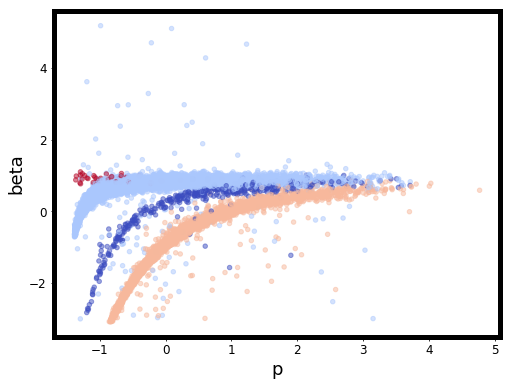

In [93]:
f_ind_1 = 0
f_ind_2 = 2
x_label = features[f_ind_1]
y_label = features[f_ind_2]

db_Z = dec_boundary(sgd_clf)(X)
print(db_Z.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, xlabel = x_label, ylabel=y_label)
ax.scatter(X[:,0],X[:,2], c= Y , cmap=plt.cm.coolwarm, s=20, alpha=.5)
# ax.scatter(X, db_Z[:,0] )
plt.show()

## Kernels

# Regression Techniques